In [1]:
import pandas as pd
# Assuming your CSV file is named "data.csv"
training_data = pd.read_csv("../gym-unbalanced-disk/disc-benchmark-files/training-val-test-data.csv", header=None)

In [2]:
# Training Data for ANN
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split 

np.random.seed(42)

ulist = training_data.iloc[:, 0].tolist()[1:]   # Input voltage
ylist = training_data.iloc[:, 1].tolist()[1:]  # Output angle

# Convert elements to floats
ulist = [float(val) for val in ulist]
ylist = [float(val) for val in ylist]

##########
na, nb = 5,5 # How many past data is used 
##########

def create_IO_data(u,y,na,nb):
    X = []
    Y = []
    for k in range(max(na,nb), len(y)):
        X.append(np.concatenate([u[k-nb:k],y[k-na:k]]))
        Y.append(y[k])
    return np.array(X), np.array(Y)

Xdata, Ydata = create_IO_data(ulist, ylist, na, nb)

Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata, Ydata) 



In [3]:
# Training Data for LSTM
import torch

def make_OE_data(udata, ydata, nf=100):
    U = [] 
    Y = [] 
    for k in range(nf,len(udata)+1):
        U.append(udata[k-nf:k]) #a)
        Y.append(ydata[k-nf:k]) #a)
    return np.array(U), np.array(Y)

nfuture = 50 # Capturing Temporal Dependencies
convert = lambda x: [torch.tensor(xi,dtype=torch.float64) for xi in x]
U_LSTM, Y_LSTM = convert(make_OE_data(ulist, ylist, nf=nfuture))

U_LSTM = torch.tensor(U_LSTM, dtype=torch.float64)
Y_LSTM = torch.tensor(Y_LSTM, dtype=torch.float64)

split_ratio = 0.8
split_index = int(split_ratio * len(U_LSTM))

# Split data into training and validation sets
Utrain, Ytrain_LSTM = U_LSTM[:split_index], Y_LSTM[:split_index]
Uval, Yval_LSTM = U_LSTM[split_index:], Y_LSTM[split_index:]


C:\Users\vddal\AppData\Local\Temp\ipykernel_53136\83530267.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  U_LSTM = torch.tensor(U_LSTM, dtype=torch.float64)
C:\Users\vddal\AppData\Local\Temp\ipykernel_53136\83530267.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_LSTM = torch.tensor(Y_LSTM, dtype=torch.float64)


In [7]:
import torch
import numpy as np

def train_model(Utrain, Ytrain_LSTM, Uval, Yval_LSTM, n_hidden_nodes, n_burn, epochs):
    # LSTM model definition
    class LSTM(nn.Module):
        def __init__(self, hidden_size):
            super(LSTM, self).__init__()
            self.hidden_size = hidden_size
            self.input_size = 1
            self.output_size = 1
            net = lambda n_in,n_out: nn.Sequential(nn.Linear(n_in,10),nn.Sigmoid(),nn.Linear(10,n_out)) #short hand for a 1 hidden layer NN
            self.lstm = nn.LSTM(input_size=self.input_size,  hidden_size=hidden_size,  batch_first=True).double() #i)
            self.h2o = net(hidden_size + self.input_size, self.output_size).double() #i)

        def forward(self, inputs):
            hiddens, (h_n, c_n) = self.lstm(inputs[:,:,None]) #i)
            combined = torch.cat((hiddens,inputs[:,:,None]),dim=2) #i)
            if False: #two ways to solve this #i)
                y_predict = [] #i)
                for i in range(combined.shape[1]):  #i)
                    y_predict.append(self.h2o(combined[:,i,:])[:,0])  #i)
                y_predict = torch.stack(y_predict,dim=1)  #i)
            else: #this is faster but more complex #i)
                #reshape from (N_batch, N_time, N_hidden) to (N_batch*N_time, N_hidden) #i)
                h2o_input = combined.view(-1,self.hidden_size+self.input_size) #i)
                #apply and reshape from (N_batch*N_time,1) to (N_batch,N_time) #i)
                y_predict =  self.h2o(h2o_input).view(inputs.shape[0],inputs.shape[1])  #new #i)
            
            return y_predict

    # Training parameters
    batch_size = 64
    lr = 0.001

    model = LSTM(n_hidden_nodes)
    optimizer = torch.optim.Adam(model.parameters(),lr= lr)

    # Convert data to PyTorch tensors
    Utrain, Uval, Ytrain_LSTM, Yval_LSTM = [torch.as_tensor(x) for x in [Utrain, Uval, Ytrain_LSTM, Yval_LSTM]]

    # Shuffle indices for batch processing
    ids = np.arange(len(Utrain), dtype=int)

    train_losses = []
    val_losses = []
    best_val_loss = 10000

    for epoch in range(epochs):
        np.random.shuffle(ids)
        for i in range(0, len(Utrain), batch_size):
            ids_now = ids[i:i + batch_size]
            Uin = Utrain[ids_now]
            Y_real = Ytrain_LSTM[ids_now]

            Y_predict = model.forward(inputs=Uin)
            residual = Y_real - Y_predict
            Loss = torch.mean(residual[:, n_burn:] ** 2)

            optimizer.zero_grad()
            Loss.backward()
            optimizer.step()

        with torch.no_grad():
            Loss_val = torch.mean((model(inputs=Uval)[:, n_burn:] - Yval_LSTM[:, n_burn:]) ** 2) ** 0.5
            Loss_train = torch.mean((model(inputs=Utrain)[:, n_burn:] - Ytrain_LSTM[:, n_burn:]) ** 2) ** 0.5

            val_losses.append(Loss_val.item())
            train_losses.append(Loss_train.item())

            if Loss_val < best_val_loss:
                best_val_loss = Loss_val

    return train_losses, val_losses

# Grid search parameters
n_hidden_nodes_list = [15, 20, 25]
n_burn_list = [30, 35, 40]
epochs_list = [10]

# Initialize best parameters and losses
best_params = {'n_hidden_nodes': None, 'n_burn': None, 'epochs': None}
best_val_loss = float('inf')

# Perform grid search
for n_hidden_nodes in n_hidden_nodes_list:
    for n_burn in n_burn_list:
        for epochs in epochs_list:
            print(f'Training with n_hidden_nodes={n_hidden_nodes}, n_burn={n_burn}, epochs={epochs}')
            train_losses, val_losses = train_model(Utrain, Ytrain_LSTM, Uval, Yval_LSTM, n_hidden_nodes, n_burn, epochs)
            print('Last epoch Train Loss: ',train_losses[-1])
            print('Last epoch Val Loss: ',val_losses[-1])
            if val_losses[-1] < best_val_loss:
                best_val_loss = val_losses[-1]
                best_params['n_hidden_nodes'] = n_hidden_nodes
                best_params['n_burn'] = n_burn
                best_params['epochs'] = epochs

print(f'Best parameters: {best_params}')


Training with n_hidden_nodes=15, n_burn=30, epochs=10
Last epoch Train Loss:  0.18792911188478909
Last epoch Val Loss:  0.22721436166722764
Training with n_hidden_nodes=15, n_burn=35, epochs=10
Last epoch Train Loss:  0.17828501576475111
Last epoch Val Loss:  0.22618791402141075
Training with n_hidden_nodes=15, n_burn=40, epochs=10
Last epoch Train Loss:  0.1739574625838414
Last epoch Val Loss:  0.22258900450357563
Training with n_hidden_nodes=20, n_burn=30, epochs=10
Last epoch Train Loss:  0.18593577220478477
Last epoch Val Loss:  0.2355437053773334
Training with n_hidden_nodes=20, n_burn=35, epochs=10
Last epoch Train Loss:  0.18161270864392337
Last epoch Val Loss:  0.22443313916018523
Training with n_hidden_nodes=20, n_burn=40, epochs=10
Last epoch Train Loss:  0.17091377716134123
Last epoch Val Loss:  0.2173982748502488
Training with n_hidden_nodes=25, n_burn=30, epochs=10
Last epoch Train Loss:  0.18225049992869194
Last epoch Val Loss:  0.22857268561408128
Training with n_hidden_

epoch=0, Validation NRMS=23.76%, Train NRMS=19.73%
epoch=1, Validation NRMS=23.33%, Train NRMS=19.37%
epoch=2, Validation NRMS=24.34%, Train NRMS=19.58%
epoch=3, Validation NRMS=23.37%, Train NRMS=19.04%
epoch=4, Validation NRMS=23.22%, Train NRMS=19.10%
epoch=5, Validation NRMS=23.77%, Train NRMS=19.45%
epoch=6, Validation NRMS=23.62%, Train NRMS=18.98%
epoch=7, Validation NRMS=23.06%, Train NRMS=18.96%
epoch=8, Validation NRMS=23.51%, Train NRMS=18.92%
epoch=9, Validation NRMS=23.35%, Train NRMS=18.75%


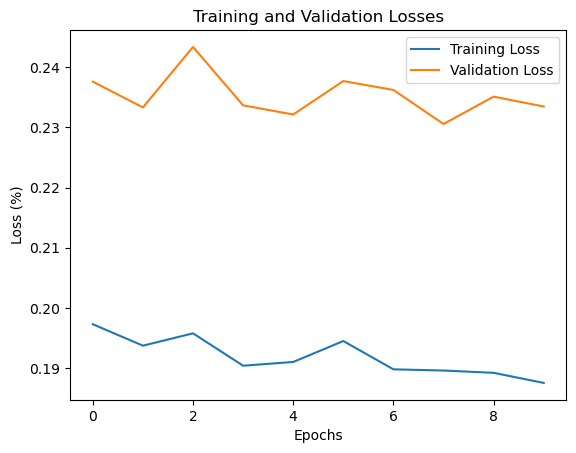

In [5]:
# Best Parameters
n_hidden_nodes = best_params['n_hidden_nodes']
n_burn = best_params['n_burn']
epochs = best_params['epochs']


# LSTM
class LSTM(nn.Module):
    def __init__(self, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = 1
        self.output_size = 1
        net = lambda n_in,n_out: nn.Sequential(nn.Linear(n_in,40),nn.Sigmoid(),nn.Linear(40,n_out)) #short hand for a 1 hidden layer NN
        self.lstm = nn.LSTM(input_size=self.input_size,  hidden_size=hidden_size,  batch_first=True).double() #i)
        self.h2o = net(hidden_size + self.input_size, self.output_size).double() #i)

    def forward(self, inputs):
        hiddens, (h_n, c_n) = self.lstm(inputs[:,:,None]) #i)
        combined = torch.cat((hiddens,inputs[:,:,None]),dim=2) #i)
        if False: #two ways to solve this #i)
            y_predict = [] #i)
            for i in range(combined.shape[1]):  #i)
                y_predict.append(self.h2o(combined[:,i,:])[:,0])  #i)
            y_predict = torch.stack(y_predict,dim=1)  #i)
        else: #this is faster but more complex #i)
            #reshape from (N_batch, N_time, N_hidden) to (N_batch*N_time, N_hidden) #i)
            h2o_input = combined.view(-1,self.hidden_size+self.input_size) #i)
            #apply and reshape from (N_batch*N_time,1) to (N_batch,N_time) #i)
            y_predict =  self.h2o(h2o_input).view(inputs.shape[0],inputs.shape[1])  #new #i)
        
        return y_predict
        

# Training
batch_size = 64 #Xtrain.shape[1]

model = LSTM(n_hidden_nodes) 
optimizer = torch.optim.Adam(model.parameters()) 
Utrain, Uval, Ytrain_LSTM, Yval_LSTM = [torch.as_tensor(x) for x in [Utrain, Uval, Ytrain_LSTM, Yval_LSTM]] 

ids = np.arange(len(Utrain),dtype=int) 

train_losses = []
val_losses = []
best_val_loss = 10000

for epoch in range(epochs):
    np.random.shuffle(ids) #inspace shuffle of the ids of the training set to select a random subset 
    for i in range(0,len(Utrain),batch_size):
        ids_now = ids[i:i+batch_size] #the ids of the current batch
        Uin = Utrain[ids_now] #d)
        Y_real = Ytrain_LSTM[ids_now] #d)

        Y_predict = model.forward(inputs=Uin)


        residual = Y_real - Y_predict #d)
        Loss = torch.mean(residual[:,n_burn:]**2) #d)

        
        optimizer.zero_grad()  #d)
        Loss.backward()  #d)
        optimizer.step()  #d)

    
    with torch.no_grad(): #monitor
        Loss_val = torch.mean((model(inputs=Uval)[:,n_burn:] - Yval_LSTM[:,n_burn:])**2)**0.5
        Loss_train = torch.mean((model(inputs=Utrain)[:,n_burn:] - Ytrain_LSTM[:,n_burn:])**2)**0.5
        print(f'epoch={epoch}, Validation NRMS={Loss_val.item():.2%}, Train NRMS={Loss_train.item():.2%}')

        val_losses.append(Loss_val.item())
        train_losses.append(Loss_train.item())

        if Loss_val < best_val_loss:
            best_val_loss = Loss_val
            best_val_epoch = epoch
            #torch.save(model.state_dict(), f"best_model.pth") #saving the model too much was giving issues
            

torch.save(model.state_dict(), "LSTM_model_1.pth")

# Plot the losses
plt.plot(range(epochs), [loss for loss in train_losses], label='Training Loss')
plt.plot(range(epochs), [loss for loss in val_losses], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [6]:
out = np.load('../gym-unbalanced-disk/disc-benchmark-files/training-val-test-data.npz')
th_train = out['th'] #th[0],th[1],th[2],th[3],...
u_train = out['u'] #u[0],u[1],u[2],u[3],...

# data = np.load('test-prediction-submission-file.npz')
data = np.load('../gym-unbalanced-disk/disc-benchmark-files/hidden-test-prediction-submission-file.npz')
upast_test = data['upast'] #N by u[k-15],u[k-14],...,u[k-1]
thpast_test = data['thpast'] #N by y[k-15],y[k-14],...,y[k-1]
# thpred = data['thnow'] #all zeros

#Xtrain, Ytrain = create_IO_data(u_train, th_train, na, nb)
#Xtrain = torch.tensor(Xtrain, dtype=torch.float64)

#reg = Network(Xtrain.shape[1], n_hidden_nodes)
#reg.load_state_dict(torch.load("final_model.pth"))

nfuture = 5 #We only want the next output
convert = lambda x: [torch.tensor(xi,dtype=torch.float64) for xi in x]
U_LSTM, Y_LSTM = convert(make_OE_data(u_train, th_train, nf=nfuture))

# U_LSTM = torch.tensor(U_LSTM, dtype=torch.float64)
# Y_LSTM = torch.tensor(Y_LSTM, dtype=torch.float64)


reg = LSTM(n_hidden_nodes) 
reg.load_state_dict(torch.load("LSTM_model.pth"))

Ytrain_pred = reg(U_LSTM)

Ytrain_pred = Ytrain_pred.detach().numpy()
Y_LSTM = Y_LSTM.detach().numpy()


print('train prediction errors:')
print('RMS:', np.mean((Ytrain_pred-Y_LSTM)**2)**0.5,'radians')
print('RMS:', np.mean((Ytrain_pred-Y_LSTM)**2)**0.5/(2*np.pi)*360,'degrees')
print('NRMS:', np.mean((Ytrain_pred-Y_LSTM)**2)**0.5/Ytrain.std()*100,'%')

#only select the ones that are used in the example
Xtest = np.concatenate([upast_test[:,15-nb:], thpast_test[:,15-na:]],axis=1)
Xtest = torch.tensor(Xtest, dtype=torch.float64)

Ypredict = reg(Xtest)
Ypredict = Ypredict.detach().numpy()

assert len(Ypredict)==len(upast_test), 'number of samples changed!!'

np.savez('../gym-unbalanced-disk/disc-benchmark-files/hidden-test-prediction-example-submission-file.npz', upast=upast_test, thpast=thpast_test, thnow=Ypredict)


FileNotFoundError: [Errno 2] No such file or directory: 'LSTM_model.pth'

In [ ]:
# Simulation
out = np.load('../gym-unbalanced-disk/disc-benchmark-files/training-val-test-data.npz')
th_train = out['th'] #th[0],th[1],th[2],th[3],...
u_train = out['u'] #u[0],u[1],u[2],u[3],...

data = np.load('../gym-unbalanced-disk/disc-benchmark-files/hidden-test-simulation-submission-file.npz')
u_test = data['u']
th_test = data['th'] #only the first 50 values are filled the rest are zeros


#Xtrain, Ytrain = create_IO_data(u_train, th_train, na, nb)
#Xtrain = torch.tensor(Xtrain, dtype=torch.float64)
#reg = Network(Xtrain.shape[1], n_hidden_nodes)
#reg.load_state_dict(torch.load("final_model.pth"))

nfuture = 1 #We only want the next output
convert = lambda x: [torch.tensor(xi,dtype=torch.float64) for xi in x]
U_LSTM, Y_LSTM = convert(make_OE_data(u_train, th_train, nf=nfuture))

# U_LSTM = torch.tensor(U_LSTM, dtype=torch.float64)
# Y_LSTM = torch.tensor(Y_LSTM, dtype=torch.float64)


reg = LSTM(n_hidden_nodes) 
reg.load_state_dict(torch.load("LSTM_model.pth"))

Ytrain_pred = reg(U_LSTM)

Ytrain_pred = Ytrain_pred.detach().numpy()
Y_LSTM = Y_LSTM.detach().numpy()



print('train prediction errors:')
print('RMS:', np.mean((Ytrain_pred-Y_LSTM)**2)**0.5,'radians')
print('RMS:', np.mean((Ytrain_pred-Y_LSTM)**2)**0.5/(2*np.pi)*360,'degrees')
print('NRMS:', np.mean((Ytrain_pred-Y_LSTM)**2)**0.5/Ytrain.std()*100,'%')


def simulation_IO_model(f, ulist, ylist, skip=50):

    upast = ulist[skip-na:skip].tolist() #good initialization
    ypast = ylist[skip-nb:skip].tolist()
    Y = ylist[:skip].tolist()
    for u in ulist[skip:]:
        print("1")
        upast_np = np.array([v.detach().numpy() if isinstance(v, torch.Tensor) else v for v in upast])
        ypast_np = np.array([v.detach().numpy() if isinstance(v, torch.Tensor) else v for v in ypast])
        x = np.concatenate([upast_np, ypast_np], axis=0)
        
        x = torch.tensor(x, dtype=torch.float64)
        ypred = f(x)
        Y.append(ypred[0].detach().numpy().item()) # original: Y.append(ypred.detach().numpy().item()) 
        upast.append(u)
        upast.pop(0)
        ypast.append(ypred)
        ypast.pop(0)
    return np.array(Y)

skip = len(u_train) - 1 # This way we only gets one output per sequence of inputs
# skip = max(na,nb)

th_train_sim = simulation_IO_model(lambda x: reg(x[None,:])[0], u_train, th_train, skip=skip)
print('train simulation errors:')
print('RMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5,'radians')
print('RMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5/(2*np.pi)*360,'degrees')
print('NRMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5/th_train.std()*100,'%')


th_test_sim = simulation_IO_model(lambda x: reg(x[None,:])[0], u_test, th_test, skip=skip)

assert len(th_test_sim)==len(th_test)
np.savez('../gym-unbalanced-disk/disc-benchmark-files/hidden-test-simulation-example-submission-file.npz', th=th_test_sim, u=u_test)

train prediction errors:
RMS: 0.48027007499808033 radians
RMS: 27.51744832382152 degrees
NRMS: 100.4613124793269 %
1
train simulation errors:
RMS: 0.12624325853100876 radians
RMS: 7.233205905805727 degrees
NRMS: 26.337039326415336 %
